<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [AE1] - Building and training an AE denoiser model
<!-- DESC --> Episode 1 : After construction, the model is trained with noisy data from the MNIST dataset.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a denoizing **autoencoder** neurals network (AE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST.  
The use of a GPU is often indispensable.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

Thanks to **François Chollet** whose VAE example has greatly inspired this example.  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from modules.callbacks          import ImagesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys,json,time,datetime
from importlib import reload
from IPython.display import display,Image,Markdown,HTML
import h5py

from skimage import io
from skimage.util import random_noise

import modules.AE
from modules.AE           import AE
from modules.loader_MNIST import Loader_MNIST
from modules.callbacks    import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('AE1')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.12
Notebook id          : AE1
Run time             : Tuesday 09 February 2021, 19:56:09
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Prepare data
### 2.1 - Get MNIST dataset

In [2]:
x_data, y_data = Loader_MNIST.get()

Dataset loaded.
Normalized.
Expanded.
Concatenate.
x shape : (70000, 28, 28, 1)
y shape : (70000,)


### 2.2 - Add noise to dataset
We will add noise to our input dataset (x_data)  
Our goal is to predict noiselessly data (y_data)

In [3]:
def noise_it(x_data, about):
    for i,image in enumerate(x_data):
        pwk.update_progress(about,i+1,len(x_data))
        image=random_noise(image, mode='gaussian', mean=0, var=0.3)
        image=random_noise(image, mode='s&p',      amount=0.2, salt_vs_pepper=0.5)
        image=random_noise(image, mode='poisson') 
        image=random_noise(image, mode='speckle',  mean=0, var=0.1)
        x_data[i]=image
    return x_data


# ---- What we want to predict
#
y_data = np.copy(x_data)

# ---- Add noise to input data
#
x_data = noise_it(x_data, 'Add noise to x_train :')


Add noise to x_train : [########################################] 100.0% of 70000


### 2.3 - Have a look

Noisy dataset (x_data) :  (70000, 28, 28, 1)
Clean dataset (y_data) :  (70000, 28, 28, 1)


<br>**Noisy images (input data)**

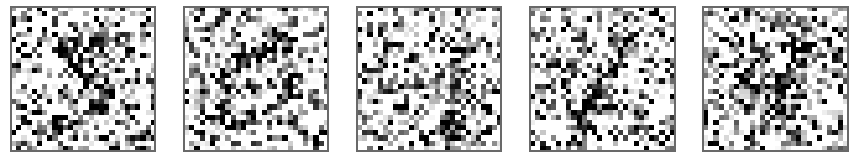

<br>**Original images we want to obtain (output data)**

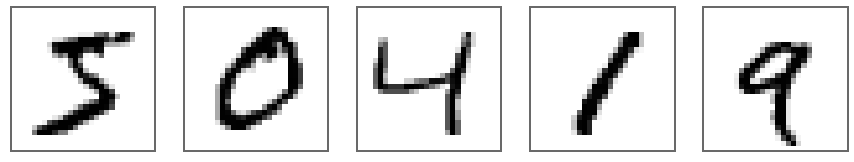

In [4]:
print('Noisy dataset (x_data) : ',x_data.shape)
print('Clean dataset (y_data) : ',y_data.shape)

pwk.subtitle('Noisy images (input data)')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=3,y_size=3, interpolation=None, save_as='01-noisy')
pwk.subtitle('Original images we want to obtain (output data)')
pwk.plot_images(y_data[:5], None, indices='all', columns=5, x_size=3,y_size=3, interpolation=None, save_as='02-original')


### 2.4 - Shuffle and split dataset

In [5]:
p = np.random.permutation(len(x_data))
x_data, y_data = x_data[p], y_data[p]
x_train, y_train = x_data[:60000], y_data[:60000]
x_test,  y_test  = x_data[60000:], y_data[60000:]

print(f'x_train:{x_train.shape}  y_train:{y_train.shape}')
print(f'x_test :{x_test.shape}  y_test :{y_test.shape}')

x_train:(60000, 28, 28, 1)  y_train:(60000, 28, 28, 1)
x_test :(10000, 28, 28, 1)  y_test :(10000, 28, 28, 1)


### 2.5 - Save it

In [6]:
pwk.mkdir('./data')

with h5py.File('./data/mnist-noisy.h5', "w") as f:
    f.create_dataset("x_train", data=x_train)
    f.create_dataset("y_train", data=y_train)
    f.create_dataset("x_test",  data=x_test)
    f.create_dataset("y_test",  data=y_test)
    print('Saved.')

Saved.


## Step 3 - Build model

In [7]:
latent_dim = 10

#### Encoder

In [8]:
reload(modules.AE)
from modules.AE          import AE

inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
encoder.compile()
# encoder.summary()

#### Decoder

In [9]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()
# decoder.summary()

#### AE


In [10]:
ae = AE(encoder, decoder)

ae.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')

## Step 4 - Train
20' on a CPU  
1'12 on a GPU (V100, IDRIS)

In [11]:
# ---- Callback : Images
pwk.mkdir('./run/images')
filename = './run/images/image-{epoch:03d}-{i:02d}.jpg'
callback_images = ImagesCallback(filename, x=x_test[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Best model
pwk.mkdir('./run/models')
filename = './run/models/best_model'
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = './run/logs'
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

callbacks_list = [callback_images, callback_bestmodel, callback_tensorboard]

In [12]:
%%time

n          = 60000
batch_size = 128
epochs     = 30

history = ae.fit(x_train[:n],y_train[:n], epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/30


  1/469 [..............................] - ETA: 28:01 - loss: 0.6931

  3/469 [..............................] - ETA: 23s - loss: 0.6921  

 15/469 [..............................] - ETA: 4s - loss: 0.6573 

 28/469 [>.............................] - ETA: 3s - loss: 0.5917

 41/469 [=>............................] - ETA: 2s - loss: 0.5408

 54/469 [==>...........................] - ETA: 2s - loss: 0.5039

 67/469 [===>..........................] - ETA: 2s - loss: 0.4763

 80/469 [====>.........................] - ETA: 2s - loss: 0.4551

 93/469 [====>.........................] - ETA: 1s - loss: 0.4380

106/469 [=====>........................] - ETA: 1s - loss: 0.4241

119/469 [======>.......................] - ETA: 1s - loss: 0.4125

132/469 [=======>......................] - ETA: 1s - loss: 0.4026

145/469 [========>.....................] - ETA: 1s - loss: 0.3941

158/469 [=========>....................] - ETA: 1s - loss: 0.3867

171/469 [=========>....................] - ETA: 1s - loss: 0.3802

184/469 [==========>...................] - ETA: 1s - loss: 0.3744

197/469 [===========>..................] - ETA: 1s - loss: 0.3692

210/469 [============>.................] - ETA: 1s - loss: 0.3646

223/469 [=============>................] - ETA: 1s - loss: 0.3604

236/469 [==============>...............] - ETA: 1s - loss: 0.3566

249/469 [==============>...............] - ETA: 0s - loss: 0.3530

250/469 [==============>...............] - ETA: 1s - loss: 0.3528

263/469 [===============>..............] - ETA: 1s - loss: 0.3496

276/469 [================>.............] - ETA: 0s - loss: 0.3466

289/469 [=================>............] - ETA: 0s - loss: 0.3438

302/469 [==================>...........] - ETA: 0s - loss: 0.3412

315/469 [===================>..........] - ETA: 0s - loss: 0.3388

328/469 [===================>..........] - ETA: 0s - loss: 0.3366

341/469 [====================>.........] - ETA: 0s - loss: 0.3344

354/469 [=====================>........] - ETA: 0s - loss: 0.3324

367/469 [======================>.......] - ETA: 0s - loss: 0.3305

380/469 [=======================>......] - ETA: 0s - loss: 0.3286

393/469 [========================>.....] - ETA: 0s - loss: 0.3269

406/469 [========================>.....] - ETA: 0s - loss: 0.3252

419/469 [=========================>....] - ETA: 0s - loss: 0.3235

432/469 [==========================>...] - ETA: 0s - loss: 0.3220

445/469 [===========================>..] - ETA: 0s - loss: 0.3204

458/469 [============================>.] - ETA: 0s - loss: 0.3189

469/469 [==============================] - ETA: 0s - loss: 0.3177

469/469 [==============================] - 6s 5ms/step - loss: 0.3176


           (saved) Epoch 2/30
  1/469 [..............................] - ETA: 2s - loss: 0.2170

 14/469 [..............................] - ETA: 1s - loss: 0.2112

 28/469 [>.............................] - ETA: 1s - loss: 0.2092

 42/469 [=>............................] - ETA: 1s - loss: 0.2082

 56/469 [==>...........................] - ETA: 1s - loss: 0.2074

 70/469 [===>..........................] - ETA: 1s - loss: 0.2067

 84/469 [====>.........................] - ETA: 1s - loss: 0.2061

 98/469 [=====>........................] - ETA: 1s - loss: 0.2055

112/469 [======>.......................] - ETA: 1s - loss: 0.2049

126/469 [=======>......................] - ETA: 1s - loss: 0.2044

140/469 [=======>......................] - ETA: 1s - loss: 0.2039

154/469 [========>.....................] - ETA: 1s - loss: 0.2034

168/469 [=========>....................] - ETA: 1s - loss: 0.2030

182/469 [==========>...................] - ETA: 1s - loss: 0.2025

196/469 [===========>..................] - ETA: 0s - loss: 0.2021

210/469 [============>.................] - ETA: 0s - loss: 0.2017

224/469 [=============>................] - ETA: 0s - loss: 0.2013

238/469 [==============>...............] - ETA: 0s - loss: 0.2009

252/469 [===============>..............] - ETA: 0s - loss: 0.2005

266/469 [================>.............] - ETA: 0s - loss: 0.2001

280/469 [================>.............] - ETA: 0s - loss: 0.1997

294/469 [=================>............] - ETA: 0s - loss: 0.1994

308/469 [==================>...........] - ETA: 0s - loss: 0.1990

322/469 [===================>..........] - ETA: 0s - loss: 0.1987

336/469 [====================>.........] - ETA: 0s - loss: 0.1983

350/469 [=====================>........] - ETA: 0s - loss: 0.1980

364/469 [======================>.......] - ETA: 0s - loss: 0.1977

378/469 [=======================>......] - ETA: 0s - loss: 0.1974

392/469 [========================>.....] - ETA: 0s - loss: 0.1971

406/469 [========================>.....] - ETA: 0s - loss: 0.1968

420/469 [=========================>....] - ETA: 0s - loss: 0.1965

434/469 [==========================>...] - ETA: 0s - loss: 0.1962

448/469 [===========================>..] - ETA: 0s - loss: 0.1959

462/469 [============================>.] - ETA: 0s - loss: 0.1956

469/469 [==============================] - 2s 4ms/step - loss: 0.1955


           (saved) 

Epoch 3/30
  1/469 [..............................] - ETA: 2s - loss: 0.1707

 15/469 [..............................] - ETA: 1s - loss: 0.1735

 29/469 [>.............................] - ETA: 1s - loss: 0.1740

 43/469 [=>............................] - ETA: 1s - loss: 0.1741

 57/469 [==>...........................] - ETA: 1s - loss: 0.1740

 71/469 [===>..........................] - ETA: 1s - loss: 0.1738

 85/469 [====>.........................] - ETA: 1s - loss: 0.1736

 99/469 [=====>........................] - ETA: 1s - loss: 0.1734

113/469 [======>.......................] - ETA: 1s - loss: 0.1733

127/469 [=======>......................] - ETA: 1s - loss: 0.1731

141/469 [========>.....................] - ETA: 1s - loss: 0.1730

155/469 [========>.....................] - ETA: 1s - loss: 0.1729

169/469 [=========>....................] - ETA: 1s - loss: 0.1728

183/469 [==========>...................] - ETA: 1s - loss: 0.1727

197/469 [===========>..................] - ETA: 0s - loss: 0.1727

211/469 [============>.................] - ETA: 0s - loss: 0.1726

225/469 [=============>................] - ETA: 0s - loss: 0.1725

239/469 [==============>...............] - ETA: 0s - loss: 0.1724

253/469 [===============>..............] - ETA: 0s - loss: 0.1724

267/469 [================>.............] - ETA: 0s - loss: 0.1723

281/469 [================>.............] - ETA: 0s - loss: 0.1722

295/469 [=================>............] - ETA: 0s - loss: 0.1722

309/469 [==================>...........] - ETA: 0s - loss: 0.1721

323/469 [===================>..........] - ETA: 0s - loss: 0.1721

337/469 [====================>.........] - ETA: 0s - loss: 0.1720

351/469 [=====================>........] - ETA: 0s - loss: 0.1719

365/469 [======================>.......] - ETA: 0s - loss: 0.1719

379/469 [=======================>......] - ETA: 0s - loss: 0.1718

393/469 [========================>.....] - ETA: 0s - loss: 0.1718

407/469 [=========================>....] - ETA: 0s - loss: 0.1717

421/469 [=========================>....] - ETA: 0s - loss: 0.1717

435/469 [==========================>...] - ETA: 0s - loss: 0.1716

449/469 [===========================>..] - ETA: 0s - loss: 0.1715

463/469 [============================>.] - ETA: 0s - loss: 0.1715

469/469 [==============================] - 2s 4ms/step - loss: 0.1714


           (saved) 

Epoch 4/30
  1/469 [..............................] - ETA: 1s - loss: 0.1661

 15/469 [..............................] - ETA: 1s - loss: 0.1651

 29/469 [>.............................] - ETA: 1s - loss: 0.1649

 43/469 [=>............................] - ETA: 1s - loss: 0.1648

 57/469 [==>...........................] - ETA: 1s - loss: 0.1648

 71/469 [===>..........................] - ETA: 1s - loss: 0.1647

 85/469 [====>.........................] - ETA: 1s - loss: 0.1647

 99/469 [=====>........................] - ETA: 1s - loss: 0.1647

113/469 [======>.......................] - ETA: 1s - loss: 0.1646

127/469 [=======>......................] - ETA: 1s - loss: 0.1646

141/469 [========>.....................] - ETA: 1s - loss: 0.1645

155/469 [========>.....................] - ETA: 1s - loss: 0.1645

169/469 [=========>....................] - ETA: 1s - loss: 0.1644

183/469 [==========>...................] - ETA: 1s - loss: 0.1644

197/469 [===========>..................] - ETA: 0s - loss: 0.1643

211/469 [============>.................] - ETA: 0s - loss: 0.1643

225/469 [=============>................] - ETA: 0s - loss: 0.1642

239/469 [==============>...............] - ETA: 0s - loss: 0.1642

253/469 [===============>..............] - ETA: 0s - loss: 0.1641

267/469 [================>.............] - ETA: 0s - loss: 0.1641

281/469 [================>.............] - ETA: 0s - loss: 0.1640

295/469 [=================>............] - ETA: 0s - loss: 0.1640

310/469 [==================>...........] - ETA: 0s - loss: 0.1639

324/469 [===================>..........] - ETA: 0s - loss: 0.1639

338/469 [====================>.........] - ETA: 0s - loss: 0.1639

352/469 [=====================>........] - ETA: 0s - loss: 0.1638

366/469 [======================>.......] - ETA: 0s - loss: 0.1638

380/469 [=======================>......] - ETA: 0s - loss: 0.1638

394/469 [========================>.....] - ETA: 0s - loss: 0.1637

408/469 [=========================>....] - ETA: 0s - loss: 0.1637

422/469 [=========================>....] - ETA: 0s - loss: 0.1636

436/469 [==========================>...] - ETA: 0s - loss: 0.1636

450/469 [===========================>..] - ETA: 0s - loss: 0.1636

464/469 [============================>.] - ETA: 0s - loss: 0.1635

469/469 [==============================] - 2s 4ms/step - loss: 0.1635


           (saved) Epoch 5/30
  1/469 [..............................] - ETA: 1s - loss: 0.1628

 15/469 [..............................] - ETA: 1s - loss: 0.1594

 29/469 [>.............................] - ETA: 1s - loss: 0.1592

 43/469 [=>............................] - ETA: 1s - loss: 0.1595

 57/469 [==>...........................] - ETA: 1s - loss: 0.1595

 71/469 [===>..........................] - ETA: 1s - loss: 0.1595

 85/469 [====>.........................] - ETA: 1s - loss: 0.1595

 99/469 [=====>........................] - ETA: 1s - loss: 0.1595

113/469 [======>.......................] - ETA: 1s - loss: 0.1596

127/469 [=======>......................] - ETA: 1s - loss: 0.1596

141/469 [========>.....................] - ETA: 1s - loss: 0.1596

155/469 [========>.....................] - ETA: 1s - loss: 0.1596

169/469 [=========>....................] - ETA: 1s - loss: 0.1595

183/469 [==========>...................] - ETA: 1s - loss: 0.1595

197/469 [===========>..................] - ETA: 0s - loss: 0.1595

211/469 [============>.................] - ETA: 0s - loss: 0.1595

225/469 [=============>................] - ETA: 0s - loss: 0.1595

239/469 [==============>...............] - ETA: 0s - loss: 0.1594

253/469 [===============>..............] - ETA: 0s - loss: 0.1594

267/469 [================>.............] - ETA: 0s - loss: 0.1594

281/469 [================>.............] - ETA: 0s - loss: 0.1594

295/469 [=================>............] - ETA: 0s - loss: 0.1593

309/469 [==================>...........] - ETA: 0s - loss: 0.1593

323/469 [===================>..........] - ETA: 0s - loss: 0.1593

337/469 [====================>.........] - ETA: 0s - loss: 0.1593

351/469 [=====================>........] - ETA: 0s - loss: 0.1592

365/469 [======================>.......] - ETA: 0s - loss: 0.1592

379/469 [=======================>......] - ETA: 0s - loss: 0.1592

393/469 [========================>.....] - ETA: 0s - loss: 0.1592

407/469 [=========================>....] - ETA: 0s - loss: 0.1591

421/469 [=========================>....] - ETA: 0s - loss: 0.1591

435/469 [==========================>...] - ETA: 0s - loss: 0.1591

449/469 [===========================>..] - ETA: 0s - loss: 0.1591

463/469 [============================>.] - ETA: 0s - loss: 0.1591

469/469 [==============================] - 2s 4ms/step - loss: 0.1590


           (saved) Epoch 6/30
  1/469 [..............................] - ETA: 1s - loss: 0.1475

 15/469 [..............................] - ETA: 1s - loss: 0.1554

 29/469 [>.............................] - ETA: 1s - loss: 0.1555

 43/469 [=>............................] - ETA: 1s - loss: 0.1556

 57/469 [==>...........................] - ETA: 1s - loss: 0.1557

 71/469 [===>..........................] - ETA: 1s - loss: 0.1557

 85/469 [====>.........................] - ETA: 1s - loss: 0.1556

 99/469 [=====>........................] - ETA: 1s - loss: 0.1556

113/469 [======>.......................] - ETA: 1s - loss: 0.1556

127/469 [=======>......................] - ETA: 1s - loss: 0.1556

141/469 [========>.....................] - ETA: 1s - loss: 0.1556

155/469 [========>.....................] - ETA: 1s - loss: 0.1556

169/469 [=========>....................] - ETA: 1s - loss: 0.1556

183/469 [==========>...................] - ETA: 1s - loss: 0.1556

197/469 [===========>..................] - ETA: 0s - loss: 0.1556

211/469 [============>.................] - ETA: 0s - loss: 0.1556

225/469 [=============>................] - ETA: 0s - loss: 0.1556

239/469 [==============>...............] - ETA: 0s - loss: 0.1556

253/469 [===============>..............] - ETA: 0s - loss: 0.1556

267/469 [================>.............] - ETA: 0s - loss: 0.1556

281/469 [================>.............] - ETA: 0s - loss: 0.1556

295/469 [=================>............] - ETA: 0s - loss: 0.1556

309/469 [==================>...........] - ETA: 0s - loss: 0.1556

323/469 [===================>..........] - ETA: 0s - loss: 0.1556

337/469 [====================>.........] - ETA: 0s - loss: 0.1556

351/469 [=====================>........] - ETA: 0s - loss: 0.1556

365/469 [======================>.......] - ETA: 0s - loss: 0.1556

379/469 [=======================>......] - ETA: 0s - loss: 0.1556

393/469 [========================>.....] - ETA: 0s - loss: 0.1556

407/469 [=========================>....] - ETA: 0s - loss: 0.1556

421/469 [=========================>....] - ETA: 0s - loss: 0.1556

435/469 [==========================>...] - ETA: 0s - loss: 0.1556

449/469 [===========================>..] - ETA: 0s - loss: 0.1556

463/469 [============================>.] - ETA: 0s - loss: 0.1555

469/469 [==============================] - 2s 4ms/step - loss: 0.1555


           (saved) 

Epoch 7/30
  1/469 [..............................] - ETA: 1s - loss: 0.1545

 15/469 [..............................] - ETA: 1s - loss: 0.1535

 29/469 [>.............................] - ETA: 1s - loss: 0.1534

 43/469 [=>............................] - ETA: 1s - loss: 0.1534

 57/469 [==>...........................] - ETA: 1s - loss: 0.1535

 71/469 [===>..........................] - ETA: 1s - loss: 0.1535

 85/469 [====>.........................] - ETA: 1s - loss: 0.1535

 99/469 [=====>........................] - ETA: 1s - loss: 0.1534

113/469 [======>.......................] - ETA: 1s - loss: 0.1534

127/469 [=======>......................] - ETA: 1s - loss: 0.1535

141/469 [========>.....................] - ETA: 1s - loss: 0.1535

155/469 [========>.....................] - ETA: 1s - loss: 0.1535

169/469 [=========>....................] - ETA: 1s - loss: 0.1535

183/469 [==========>...................] - ETA: 1s - loss: 0.1536

197/469 [===========>..................] - ETA: 0s - loss: 0.1536

211/469 [============>.................] - ETA: 0s - loss: 0.1536

225/469 [=============>................] - ETA: 0s - loss: 0.1536

239/469 [==============>...............] - ETA: 0s - loss: 0.1536

253/469 [===============>..............] - ETA: 0s - loss: 0.1536

267/469 [================>.............] - ETA: 0s - loss: 0.1536

281/469 [================>.............] - ETA: 0s - loss: 0.1536

295/469 [=================>............] - ETA: 0s - loss: 0.1536

309/469 [==================>...........] - ETA: 0s - loss: 0.1536

323/469 [===================>..........] - ETA: 0s - loss: 0.1536

337/469 [====================>.........] - ETA: 0s - loss: 0.1536

351/469 [=====================>........] - ETA: 0s - loss: 0.1536

365/469 [======================>.......] - ETA: 0s - loss: 0.1536

379/469 [=======================>......] - ETA: 0s - loss: 0.1536

393/469 [========================>.....] - ETA: 0s - loss: 0.1536

407/469 [=========================>....] - ETA: 0s - loss: 0.1535

421/469 [=========================>....] - ETA: 0s - loss: 0.1535

435/469 [==========================>...] - ETA: 0s - loss: 0.1535

449/469 [===========================>..] - ETA: 0s - loss: 0.1535

463/469 [============================>.] - ETA: 0s - loss: 0.1535

469/469 [==============================] - 2s 4ms/step - loss: 0.1535


           (saved) 

Epoch 8/30
  1/469 [..............................] - ETA: 1s - loss: 0.1516

 15/469 [..............................] - ETA: 1s - loss: 0.1518

 29/469 [>.............................] - ETA: 1s - loss: 0.1522

 43/469 [=>............................] - ETA: 1s - loss: 0.1522

 57/469 [==>...........................] - ETA: 1s - loss: 0.1523

 71/469 [===>..........................] - ETA: 1s - loss: 0.1522

 85/469 [====>.........................] - ETA: 1s - loss: 0.1522

 99/469 [=====>........................] - ETA: 1s - loss: 0.1521

113/469 [======>.......................] - ETA: 1s - loss: 0.1521

127/469 [=======>......................] - ETA: 1s - loss: 0.1521

141/469 [========>.....................] - ETA: 1s - loss: 0.1521

155/469 [========>.....................] - ETA: 1s - loss: 0.1521

169/469 [=========>....................] - ETA: 1s - loss: 0.1521

183/469 [==========>...................] - ETA: 1s - loss: 0.1521

197/469 [===========>..................] - ETA: 0s - loss: 0.1521

211/469 [============>.................] - ETA: 0s - loss: 0.1521

225/469 [=============>................] - ETA: 0s - loss: 0.1521

239/469 [==============>...............] - ETA: 0s - loss: 0.1521

253/469 [===============>..............] - ETA: 0s - loss: 0.1521

267/469 [================>.............] - ETA: 0s - loss: 0.1521

281/469 [================>.............] - ETA: 0s - loss: 0.1521

294/469 [=================>............] - ETA: 0s - loss: 0.1520

307/469 [==================>...........] - ETA: 0s - loss: 0.1520

320/469 [===================>..........] - ETA: 0s - loss: 0.1520

333/469 [====================>.........] - ETA: 0s - loss: 0.1520

346/469 [=====================>........] - ETA: 0s - loss: 0.1520

359/469 [=====================>........] - ETA: 0s - loss: 0.1520

372/469 [======================>.......] - ETA: 0s - loss: 0.1520

385/469 [=======================>......] - ETA: 0s - loss: 0.1520

398/469 [========================>.....] - ETA: 0s - loss: 0.1520

411/469 [=========================>....] - ETA: 0s - loss: 0.1519

424/469 [==========================>...] - ETA: 0s - loss: 0.1519

437/469 [==========================>...] - ETA: 0s - loss: 0.1519

450/469 [===========================>..] - ETA: 0s - loss: 0.1519

463/469 [============================>.] - ETA: 0s - loss: 0.1519

469/469 [==============================] - 2s 4ms/step - loss: 0.1519


           (saved) Epoch 9/30
  1/469 [..............................] - ETA: 1s - loss: 0.1490

 14/469 [..............................] - ETA: 1s - loss: 0.1486

 27/469 [>.............................] - ETA: 1s - loss: 0.1486

 40/469 [=>............................] - ETA: 1s - loss: 0.1487

 53/469 [==>...........................] - ETA: 1s - loss: 0.1488

 66/469 [===>..........................] - ETA: 1s - loss: 0.1489

 79/469 [====>.........................] - ETA: 1s - loss: 0.1490

 92/469 [====>.........................] - ETA: 1s - loss: 0.1491

105/469 [=====>........................] - ETA: 1s - loss: 0.1492

118/469 [======>.......................] - ETA: 1s - loss: 0.1493

131/469 [=======>......................] - ETA: 1s - loss: 0.1493

144/469 [========>.....................] - ETA: 1s - loss: 0.1494

157/469 [=========>....................] - ETA: 1s - loss: 0.1494

170/469 [=========>....................] - ETA: 1s - loss: 0.1495

183/469 [==========>...................] - ETA: 1s - loss: 0.1495

196/469 [===========>..................] - ETA: 1s - loss: 0.1496

209/469 [============>.................] - ETA: 1s - loss: 0.1496

222/469 [=============>................] - ETA: 0s - loss: 0.1496

235/469 [==============>...............] - ETA: 0s - loss: 0.1496

248/469 [==============>...............] - ETA: 0s - loss: 0.1497

261/469 [===============>..............] - ETA: 0s - loss: 0.1497

274/469 [================>.............] - ETA: 0s - loss: 0.1497

287/469 [=================>............] - ETA: 0s - loss: 0.1497

300/469 [==================>...........] - ETA: 0s - loss: 0.1497

313/469 [===================>..........] - ETA: 0s - loss: 0.1498

326/469 [===================>..........] - ETA: 0s - loss: 0.1498

339/469 [====================>.........] - ETA: 0s - loss: 0.1498

352/469 [=====================>........] - ETA: 0s - loss: 0.1498

365/469 [======================>.......] - ETA: 0s - loss: 0.1498

378/469 [=======================>......] - ETA: 0s - loss: 0.1498

391/469 [========================>.....] - ETA: 0s - loss: 0.1498

404/469 [========================>.....] - ETA: 0s - loss: 0.1498

417/469 [=========================>....] - ETA: 0s - loss: 0.1498

430/469 [==========================>...] - ETA: 0s - loss: 0.1499

443/469 [===========================>..] - ETA: 0s - loss: 0.1499

456/469 [============================>.] - ETA: 0s - loss: 0.1499

469/469 [==============================] - ETA: 0s - loss: 0.1499

469/469 [==============================] - 2s 4ms/step - loss: 0.1499


           (saved) 

Epoch 10/30
  1/469 [..............................] - ETA: 2s - loss: 0.1431

 14/469 [..............................] - ETA: 1s - loss: 0.1462

 27/469 [>.............................] - ETA: 1s - loss: 0.1468

 40/469 [=>............................] - ETA: 1s - loss: 0.1470

 53/469 [==>...........................] - ETA: 1s - loss: 0.1471

 66/469 [===>..........................] - ETA: 1s - loss: 0.1472

 79/469 [====>.........................] - ETA: 1s - loss: 0.1473

 92/469 [====>.........................] - ETA: 1s - loss: 0.1474

105/469 [=====>........................] - ETA: 1s - loss: 0.1475

118/469 [======>.......................] - ETA: 1s - loss: 0.1476

131/469 [=======>......................] - ETA: 1s - loss: 0.1476

144/469 [========>.....................] - ETA: 1s - loss: 0.1477

157/469 [=========>....................] - ETA: 1s - loss: 0.1478

170/469 [=========>....................] - ETA: 1s - loss: 0.1478

183/469 [==========>...................] - ETA: 1s - loss: 0.1479

196/469 [===========>..................] - ETA: 1s - loss: 0.1479

209/469 [============>.................] - ETA: 1s - loss: 0.1480

222/469 [=============>................] - ETA: 0s - loss: 0.1480

235/469 [==============>...............] - ETA: 0s - loss: 0.1481

248/469 [==============>...............] - ETA: 0s - loss: 0.1481

261/469 [===============>..............] - ETA: 0s - loss: 0.1481

274/469 [================>.............] - ETA: 0s - loss: 0.1482

287/469 [=================>............] - ETA: 0s - loss: 0.1482

300/469 [==================>...........] - ETA: 0s - loss: 0.1482

313/469 [===================>..........] - ETA: 0s - loss: 0.1483

326/469 [===================>..........] - ETA: 0s - loss: 0.1483

339/469 [====================>.........] - ETA: 0s - loss: 0.1483

352/469 [=====================>........] - ETA: 0s - loss: 0.1483

365/469 [======================>.......] - ETA: 0s - loss: 0.1484

378/469 [=======================>......] - ETA: 0s - loss: 0.1484

391/469 [========================>.....] - ETA: 0s - loss: 0.1484

404/469 [========================>.....] - ETA: 0s - loss: 0.1484

417/469 [=========================>....] - ETA: 0s - loss: 0.1485

430/469 [==========================>...] - ETA: 0s - loss: 0.1485

443/469 [===========================>..] - ETA: 0s - loss: 0.1485

456/469 [============================>.] - ETA: 0s - loss: 0.1485

469/469 [==============================] - ETA: 0s - loss: 0.1485

469/469 [==============================] - 2s 4ms/step - loss: 0.1485


           (saved) Epoch 11/30
  1/469 [..............................] - ETA: 2s - loss: 0.1512

 14/469 [..............................] - ETA: 1s - loss: 0.1478

 27/469 [>.............................] - ETA: 1s - loss: 0.1476

 40/469 [=>............................] - ETA: 1s - loss: 0.1476

 53/469 [==>...........................] - ETA: 1s - loss: 0.1476

 66/469 [===>..........................] - ETA: 1s - loss: 0.1476

 79/469 [====>.........................] - ETA: 1s - loss: 0.1476

 92/469 [====>.........................] - ETA: 1s - loss: 0.1476

105/469 [=====>........................] - ETA: 1s - loss: 0.1476

118/469 [======>.......................] - ETA: 1s - loss: 0.1476

131/469 [=======>......................] - ETA: 1s - loss: 0.1476

144/469 [========>.....................] - ETA: 1s - loss: 0.1477

157/469 [=========>....................] - ETA: 1s - loss: 0.1477

170/469 [=========>....................] - ETA: 1s - loss: 0.1477

183/469 [==========>...................] - ETA: 1s - loss: 0.1477

196/469 [===========>..................] - ETA: 1s - loss: 0.1478

209/469 [============>.................] - ETA: 1s - loss: 0.1478

222/469 [=============>................] - ETA: 0s - loss: 0.1478

235/469 [==============>...............] - ETA: 0s - loss: 0.1478

248/469 [==============>...............] - ETA: 0s - loss: 0.1478

261/469 [===============>..............] - ETA: 0s - loss: 0.1478

275/469 [================>.............] - ETA: 0s - loss: 0.1478

289/469 [=================>............] - ETA: 0s - loss: 0.1479

303/469 [==================>...........] - ETA: 0s - loss: 0.1479

317/469 [===================>..........] - ETA: 0s - loss: 0.1479

331/469 [====================>.........] - ETA: 0s - loss: 0.1479

345/469 [=====================>........] - ETA: 0s - loss: 0.1479

359/469 [=====================>........] - ETA: 0s - loss: 0.1479

373/469 [======================>.......] - ETA: 0s - loss: 0.1479

387/469 [=======================>......] - ETA: 0s - loss: 0.1480

401/469 [========================>.....] - ETA: 0s - loss: 0.1480

415/469 [=========================>....] - ETA: 0s - loss: 0.1480

429/469 [==========================>...] - ETA: 0s - loss: 0.1480

443/469 [===========================>..] - ETA: 0s - loss: 0.1480

457/469 [============================>.] - ETA: 0s - loss: 0.1480

469/469 [==============================] - 2s 4ms/step - loss: 0.1480


           (saved) Epoch 12/30
  1/469 [..............................] - ETA: 1s - loss: 0.1457

 15/469 [..............................] - ETA: 1s - loss: 0.1477

 29/469 [>.............................] - ETA: 1s - loss: 0.1474

 43/469 [=>............................] - ETA: 1s - loss: 0.1474

 57/469 [==>...........................] - ETA: 1s - loss: 0.1474

 71/469 [===>..........................] - ETA: 1s - loss: 0.1474

 85/469 [====>.........................] - ETA: 1s - loss: 0.1474

 99/469 [=====>........................] - ETA: 1s - loss: 0.1475

113/469 [======>.......................] - ETA: 1s - loss: 0.1475

127/469 [=======>......................] - ETA: 1s - loss: 0.1475

141/469 [========>.....................] - ETA: 1s - loss: 0.1475

155/469 [========>.....................] - ETA: 1s - loss: 0.1476

169/469 [=========>....................] - ETA: 1s - loss: 0.1476

183/469 [==========>...................] - ETA: 1s - loss: 0.1476

197/469 [===========>..................] - ETA: 0s - loss: 0.1476

211/469 [============>.................] - ETA: 0s - loss: 0.1476

225/469 [=============>................] - ETA: 0s - loss: 0.1476

239/469 [==============>...............] - ETA: 0s - loss: 0.1476

253/469 [===============>..............] - ETA: 0s - loss: 0.1475

267/469 [================>.............] - ETA: 0s - loss: 0.1475

281/469 [================>.............] - ETA: 0s - loss: 0.1475

295/469 [=================>............] - ETA: 0s - loss: 0.1475

309/469 [==================>...........] - ETA: 0s - loss: 0.1475

323/469 [===================>..........] - ETA: 0s - loss: 0.1475

337/469 [====================>.........] - ETA: 0s - loss: 0.1475

351/469 [=====================>........] - ETA: 0s - loss: 0.1475

365/469 [======================>.......] - ETA: 0s - loss: 0.1475

379/469 [=======================>......] - ETA: 0s - loss: 0.1475

393/469 [========================>.....] - ETA: 0s - loss: 0.1475

407/469 [=========================>....] - ETA: 0s - loss: 0.1475

421/469 [=========================>....] - ETA: 0s - loss: 0.1475

435/469 [==========================>...] - ETA: 0s - loss: 0.1475

449/469 [===========================>..] - ETA: 0s - loss: 0.1475

463/469 [============================>.] - ETA: 0s - loss: 0.1475

469/469 [==============================] - 2s 4ms/step - loss: 0.1475


           (saved) 

Epoch 13/30
  1/469 [..............................] - ETA: 1s - loss: 0.1363

 15/469 [..............................] - ETA: 1s - loss: 0.1450

 29/469 [>.............................] - ETA: 1s - loss: 0.1459

 43/469 [=>............................] - ETA: 1s - loss: 0.1463

 57/469 [==>...........................] - ETA: 1s - loss: 0.1466

 71/469 [===>..........................] - ETA: 1s - loss: 0.1468

 85/469 [====>.........................] - ETA: 1s - loss: 0.1468

 99/469 [=====>........................] - ETA: 1s - loss: 0.1469

113/469 [======>.......................] - ETA: 1s - loss: 0.1469

127/469 [=======>......................] - ETA: 1s - loss: 0.1469

141/469 [========>.....................] - ETA: 1s - loss: 0.1469

155/469 [========>.....................] - ETA: 1s - loss: 0.1469

169/469 [=========>....................] - ETA: 1s - loss: 0.1469

183/469 [==========>...................] - ETA: 1s - loss: 0.1469

197/469 [===========>..................] - ETA: 0s - loss: 0.1470

211/469 [============>.................] - ETA: 0s - loss: 0.1470

225/469 [=============>................] - ETA: 0s - loss: 0.1470

239/469 [==============>...............] - ETA: 0s - loss: 0.1470

253/469 [===============>..............] - ETA: 0s - loss: 0.1471

267/469 [================>.............] - ETA: 0s - loss: 0.1471

281/469 [================>.............] - ETA: 0s - loss: 0.1471

295/469 [=================>............] - ETA: 0s - loss: 0.1471

309/469 [==================>...........] - ETA: 0s - loss: 0.1471

323/469 [===================>..........] - ETA: 0s - loss: 0.1471

337/469 [====================>.........] - ETA: 0s - loss: 0.1471

351/469 [=====================>........] - ETA: 0s - loss: 0.1471

365/469 [======================>.......] - ETA: 0s - loss: 0.1471

379/469 [=======================>......] - ETA: 0s - loss: 0.1471

393/469 [========================>.....] - ETA: 0s - loss: 0.1471

407/469 [=========================>....] - ETA: 0s - loss: 0.1471

421/469 [=========================>....] - ETA: 0s - loss: 0.1471

435/469 [==========================>...] - ETA: 0s - loss: 0.1471

449/469 [===========================>..] - ETA: 0s - loss: 0.1471

463/469 [============================>.] - ETA: 0s - loss: 0.1471

469/469 [==============================] - 2s 4ms/step - loss: 0.1471


           (saved) 

Epoch 14/30
  1/469 [..............................] - ETA: 1s - loss: 0.1418

 15/469 [..............................] - ETA: 1s - loss: 0.1467

 29/469 [>.............................] - ETA: 1s - loss: 0.1469

 43/469 [=>............................] - ETA: 1s - loss: 0.1468

 57/469 [==>...........................] - ETA: 1s - loss: 0.1466

 71/469 [===>..........................] - ETA: 1s - loss: 0.1464

 85/469 [====>.........................] - ETA: 1s - loss: 0.1462

 99/469 [=====>........................] - ETA: 1s - loss: 0.1462

113/469 [======>.......................] - ETA: 1s - loss: 0.1461

127/469 [=======>......................] - ETA: 1s - loss: 0.1461

141/469 [========>.....................] - ETA: 1s - loss: 0.1461

155/469 [========>.....................] - ETA: 1s - loss: 0.1460

169/469 [=========>....................] - ETA: 1s - loss: 0.1460

183/469 [==========>...................] - ETA: 1s - loss: 0.1460

197/469 [===========>..................] - ETA: 0s - loss: 0.1460

211/469 [============>.................] - ETA: 0s - loss: 0.1460

225/469 [=============>................] - ETA: 0s - loss: 0.1460

239/469 [==============>...............] - ETA: 0s - loss: 0.1460

253/469 [===============>..............] - ETA: 0s - loss: 0.1461

267/469 [================>.............] - ETA: 0s - loss: 0.1461

281/469 [================>.............] - ETA: 0s - loss: 0.1461

295/469 [=================>............] - ETA: 0s - loss: 0.1461

309/469 [==================>...........] - ETA: 0s - loss: 0.1461

323/469 [===================>..........] - ETA: 0s - loss: 0.1461

337/469 [====================>.........] - ETA: 0s - loss: 0.1461

351/469 [=====================>........] - ETA: 0s - loss: 0.1462

365/469 [======================>.......] - ETA: 0s - loss: 0.1462

379/469 [=======================>......] - ETA: 0s - loss: 0.1462

393/469 [========================>.....] - ETA: 0s - loss: 0.1462

407/469 [=========================>....] - ETA: 0s - loss: 0.1462

421/469 [=========================>....] - ETA: 0s - loss: 0.1462

435/469 [==========================>...] - ETA: 0s - loss: 0.1462

449/469 [===========================>..] - ETA: 0s - loss: 0.1463

463/469 [============================>.] - ETA: 0s - loss: 0.1463

469/469 [==============================] - 2s 4ms/step - loss: 0.1463


           (saved) 

Epoch 15/30
  1/469 [..............................] - ETA: 1s - loss: 0.1453

 15/469 [..............................] - ETA: 1s - loss: 0.1453

 29/469 [>.............................] - ETA: 1s - loss: 0.1454

 43/469 [=>............................] - ETA: 1s - loss: 0.1455

 57/469 [==>...........................] - ETA: 1s - loss: 0.1455

 71/469 [===>..........................] - ETA: 1s - loss: 0.1455

 85/469 [====>.........................] - ETA: 1s - loss: 0.1455

 99/469 [=====>........................] - ETA: 1s - loss: 0.1455

113/469 [======>.......................] - ETA: 1s - loss: 0.1455

127/469 [=======>......................] - ETA: 1s - loss: 0.1455

141/469 [========>.....................] - ETA: 1s - loss: 0.1455

155/469 [========>.....................] - ETA: 1s - loss: 0.1455

169/469 [=========>....................] - ETA: 1s - loss: 0.1456

183/469 [==========>...................] - ETA: 1s - loss: 0.1456

197/469 [===========>..................] - ETA: 0s - loss: 0.1456

211/469 [============>.................] - ETA: 0s - loss: 0.1456

225/469 [=============>................] - ETA: 0s - loss: 0.1456

239/469 [==============>...............] - ETA: 0s - loss: 0.1456

253/469 [===============>..............] - ETA: 0s - loss: 0.1457

267/469 [================>.............] - ETA: 0s - loss: 0.1457

281/469 [================>.............] - ETA: 0s - loss: 0.1457

295/469 [=================>............] - ETA: 0s - loss: 0.1457

309/469 [==================>...........] - ETA: 0s - loss: 0.1457

323/469 [===================>..........] - ETA: 0s - loss: 0.1457

337/469 [====================>.........] - ETA: 0s - loss: 0.1457

351/469 [=====================>........] - ETA: 0s - loss: 0.1457

365/469 [======================>.......] - ETA: 0s - loss: 0.1457

379/469 [=======================>......] - ETA: 0s - loss: 0.1457

393/469 [========================>.....] - ETA: 0s - loss: 0.1458

407/469 [=========================>....] - ETA: 0s - loss: 0.1458

421/469 [=========================>....] - ETA: 0s - loss: 0.1458

435/469 [==========================>...] - ETA: 0s - loss: 0.1458

449/469 [===========================>..] - ETA: 0s - loss: 0.1458

463/469 [============================>.] - ETA: 0s - loss: 0.1458

469/469 [==============================] - 2s 4ms/step - loss: 0.1458


           (saved) Epoch 16/30
  1/469 [..............................] - ETA: 1s - loss: 0.1451

 15/469 [..............................] - ETA: 1s - loss: 0.1461

 29/469 [>.............................] - ETA: 1s - loss: 0.1463

 43/469 [=>............................] - ETA: 1s - loss: 0.1463

 57/469 [==>...........................] - ETA: 1s - loss: 0.1462

 71/469 [===>..........................] - ETA: 1s - loss: 0.1461

 85/469 [====>.........................] - ETA: 1s - loss: 0.1460

 99/469 [=====>........................] - ETA: 1s - loss: 0.1460

113/469 [======>.......................] - ETA: 1s - loss: 0.1459

127/469 [=======>......................] - ETA: 1s - loss: 0.1458

141/469 [========>.....................] - ETA: 1s - loss: 0.1458

155/469 [========>.....................] - ETA: 1s - loss: 0.1458

169/469 [=========>....................] - ETA: 1s - loss: 0.1458

183/469 [==========>...................] - ETA: 1s - loss: 0.1457

197/469 [===========>..................] - ETA: 0s - loss: 0.1457

211/469 [============>.................] - ETA: 0s - loss: 0.1457

225/469 [=============>................] - ETA: 0s - loss: 0.1457

239/469 [==============>...............] - ETA: 0s - loss: 0.1457

253/469 [===============>..............] - ETA: 0s - loss: 0.1457

267/469 [================>.............] - ETA: 0s - loss: 0.1456

281/469 [================>.............] - ETA: 0s - loss: 0.1456

295/469 [=================>............] - ETA: 0s - loss: 0.1456

309/469 [==================>...........] - ETA: 0s - loss: 0.1456

323/469 [===================>..........] - ETA: 0s - loss: 0.1456

337/469 [====================>.........] - ETA: 0s - loss: 0.1456

351/469 [=====================>........] - ETA: 0s - loss: 0.1456

365/469 [======================>.......] - ETA: 0s - loss: 0.1456

379/469 [=======================>......] - ETA: 0s - loss: 0.1456

393/469 [========================>.....] - ETA: 0s - loss: 0.1456

407/469 [=========================>....] - ETA: 0s - loss: 0.1456

421/469 [=========================>....] - ETA: 0s - loss: 0.1456

435/469 [==========================>...] - ETA: 0s - loss: 0.1456

449/469 [===========================>..] - ETA: 0s - loss: 0.1456

463/469 [============================>.] - ETA: 0s - loss: 0.1456

469/469 [==============================] - 2s 4ms/step - loss: 0.1456


           (saved) Epoch 17/30
  1/469 [..............................] - ETA: 1s - loss: 0.1451

 15/469 [..............................] - ETA: 1s - loss: 0.1451

 29/469 [>.............................] - ETA: 1s - loss: 0.1449

 43/469 [=>............................] - ETA: 1s - loss: 0.1449

 57/469 [==>...........................] - ETA: 1s - loss: 0.1448

 71/469 [===>..........................] - ETA: 1s - loss: 0.1447

 85/469 [====>.........................] - ETA: 1s - loss: 0.1447

 99/469 [=====>........................] - ETA: 1s - loss: 0.1447

113/469 [======>.......................] - ETA: 1s - loss: 0.1447

127/469 [=======>......................] - ETA: 1s - loss: 0.1447

141/469 [========>.....................] - ETA: 1s - loss: 0.1448

155/469 [========>.....................] - ETA: 1s - loss: 0.1448

169/469 [=========>....................] - ETA: 1s - loss: 0.1448

183/469 [==========>...................] - ETA: 1s - loss: 0.1448

197/469 [===========>..................] - ETA: 0s - loss: 0.1448

211/469 [============>.................] - ETA: 0s - loss: 0.1448

225/469 [=============>................] - ETA: 0s - loss: 0.1448

239/469 [==============>...............] - ETA: 0s - loss: 0.1448

253/469 [===============>..............] - ETA: 0s - loss: 0.1448

267/469 [================>.............] - ETA: 0s - loss: 0.1448

281/469 [================>.............] - ETA: 0s - loss: 0.1448

295/469 [=================>............] - ETA: 0s - loss: 0.1448

309/469 [==================>...........] - ETA: 0s - loss: 0.1448

323/469 [===================>..........] - ETA: 0s - loss: 0.1448

337/469 [====================>.........] - ETA: 0s - loss: 0.1448

351/469 [=====================>........] - ETA: 0s - loss: 0.1448

365/469 [======================>.......] - ETA: 0s - loss: 0.1448

379/469 [=======================>......] - ETA: 0s - loss: 0.1448

393/469 [========================>.....] - ETA: 0s - loss: 0.1448

407/469 [=========================>....] - ETA: 0s - loss: 0.1448

421/469 [=========================>....] - ETA: 0s - loss: 0.1449

435/469 [==========================>...] - ETA: 0s - loss: 0.1449

449/469 [===========================>..] - ETA: 0s - loss: 0.1449

463/469 [============================>.] - ETA: 0s - loss: 0.1449

469/469 [==============================] - 2s 4ms/step - loss: 0.1449


           (saved) Epoch 18/30
  1/469 [..............................] - ETA: 1s - loss: 0.1459

 15/469 [..............................] - ETA: 1s - loss: 0.1444

 29/469 [>.............................] - ETA: 1s - loss: 0.1440

 43/469 [=>............................] - ETA: 1s - loss: 0.1438

 57/469 [==>...........................] - ETA: 1s - loss: 0.1437

 71/469 [===>..........................] - ETA: 1s - loss: 0.1437

 85/469 [====>.........................] - ETA: 1s - loss: 0.1436

 99/469 [=====>........................] - ETA: 1s - loss: 0.1436

113/469 [======>.......................] - ETA: 1s - loss: 0.1436

127/469 [=======>......................] - ETA: 1s - loss: 0.1436

141/469 [========>.....................] - ETA: 1s - loss: 0.1436

155/469 [========>.....................] - ETA: 1s - loss: 0.1437

169/469 [=========>....................] - ETA: 1s - loss: 0.1437

183/469 [==========>...................] - ETA: 1s - loss: 0.1437

197/469 [===========>..................] - ETA: 0s - loss: 0.1437

211/469 [============>.................] - ETA: 0s - loss: 0.1437

225/469 [=============>................] - ETA: 0s - loss: 0.1437

239/469 [==============>...............] - ETA: 0s - loss: 0.1437

253/469 [===============>..............] - ETA: 0s - loss: 0.1437

267/469 [================>.............] - ETA: 0s - loss: 0.1438

281/469 [================>.............] - ETA: 0s - loss: 0.1438

295/469 [=================>............] - ETA: 0s - loss: 0.1438

309/469 [==================>...........] - ETA: 0s - loss: 0.1438

323/469 [===================>..........] - ETA: 0s - loss: 0.1439

337/469 [====================>.........] - ETA: 0s - loss: 0.1439

351/469 [=====================>........] - ETA: 0s - loss: 0.1439

365/469 [======================>.......] - ETA: 0s - loss: 0.1439

379/469 [=======================>......] - ETA: 0s - loss: 0.1440

393/469 [========================>.....] - ETA: 0s - loss: 0.1440

407/469 [=========================>....] - ETA: 0s - loss: 0.1440

421/469 [=========================>....] - ETA: 0s - loss: 0.1440

435/469 [==========================>...] - ETA: 0s - loss: 0.1440

449/469 [===========================>..] - ETA: 0s - loss: 0.1441

463/469 [============================>.] - ETA: 0s - loss: 0.1441

469/469 [==============================] - 2s 4ms/step - loss: 0.1441


           (saved) 

Epoch 19/30
  1/469 [..............................] - ETA: 1s - loss: 0.1451

 15/469 [..............................] - ETA: 1s - loss: 0.1437

 29/469 [>.............................] - ETA: 1s - loss: 0.1434

 43/469 [=>............................] - ETA: 1s - loss: 0.1433

 57/469 [==>...........................] - ETA: 1s - loss: 0.1432

 71/469 [===>..........................] - ETA: 1s - loss: 0.1431

 85/469 [====>.........................] - ETA: 1s - loss: 0.1431

 99/469 [=====>........................] - ETA: 1s - loss: 0.1432

113/469 [======>.......................] - ETA: 1s - loss: 0.1433

127/469 [=======>......................] - ETA: 1s - loss: 0.1433

141/469 [========>.....................] - ETA: 1s - loss: 0.1434

155/469 [========>.....................] - ETA: 1s - loss: 0.1434

169/469 [=========>....................] - ETA: 1s - loss: 0.1435

183/469 [==========>...................] - ETA: 1s - loss: 0.1435

198/469 [===========>..................] - ETA: 0s - loss: 0.1436

212/469 [============>.................] - ETA: 0s - loss: 0.1436

227/469 [=============>................] - ETA: 0s - loss: 0.1437

241/469 [==============>...............] - ETA: 0s - loss: 0.1437

255/469 [===============>..............] - ETA: 0s - loss: 0.1437

269/469 [================>.............] - ETA: 0s - loss: 0.1437

283/469 [=================>............] - ETA: 0s - loss: 0.1438

297/469 [=================>............] - ETA: 0s - loss: 0.1438

312/469 [==================>...........] - ETA: 0s - loss: 0.1438

326/469 [===================>..........] - ETA: 0s - loss: 0.1438

340/469 [====================>.........] - ETA: 0s - loss: 0.1439

355/469 [=====================>........] - ETA: 0s - loss: 0.1439

369/469 [======================>.......] - ETA: 0s - loss: 0.1439

384/469 [=======================>......] - ETA: 0s - loss: 0.1439

398/469 [========================>.....] - ETA: 0s - loss: 0.1439

413/469 [=========================>....] - ETA: 0s - loss: 0.1439

427/469 [==========================>...] - ETA: 0s - loss: 0.1440

442/469 [===========================>..] - ETA: 0s - loss: 0.1440

456/469 [============================>.] - ETA: 0s - loss: 0.1440

469/469 [==============================] - 2s 4ms/step - loss: 0.1440


           (saved) Epoch 20/30
  1/469 [..............................] - ETA: 1s - loss: 0.1452

 15/469 [..............................] - ETA: 1s - loss: 0.1449

 29/469 [>.............................] - ETA: 1s - loss: 0.1445

 43/469 [=>............................] - ETA: 1s - loss: 0.1443

 57/469 [==>...........................] - ETA: 1s - loss: 0.1442

 71/469 [===>..........................] - ETA: 1s - loss: 0.1441

 85/469 [====>.........................] - ETA: 1s - loss: 0.1441

 99/469 [=====>........................] - ETA: 1s - loss: 0.1441

113/469 [======>.......................] - ETA: 1s - loss: 0.1441

128/469 [=======>......................] - ETA: 1s - loss: 0.1440

142/469 [========>.....................] - ETA: 1s - loss: 0.1440

156/469 [========>.....................] - ETA: 1s - loss: 0.1440

170/469 [=========>....................] - ETA: 1s - loss: 0.1440

184/469 [==========>...................] - ETA: 1s - loss: 0.1440

199/469 [===========>..................] - ETA: 0s - loss: 0.1440

214/469 [============>.................] - ETA: 0s - loss: 0.1440

228/469 [=============>................] - ETA: 0s - loss: 0.1440

242/469 [==============>...............] - ETA: 0s - loss: 0.1440

256/469 [===============>..............] - ETA: 0s - loss: 0.1440

270/469 [================>.............] - ETA: 0s - loss: 0.1440

285/469 [=================>............] - ETA: 0s - loss: 0.1440

300/469 [==================>...........] - ETA: 0s - loss: 0.1440

314/469 [===================>..........] - ETA: 0s - loss: 0.1440

329/469 [====================>.........] - ETA: 0s - loss: 0.1440

343/469 [====================>.........] - ETA: 0s - loss: 0.1440

358/469 [=====================>........] - ETA: 0s - loss: 0.1440

372/469 [======================>.......] - ETA: 0s - loss: 0.1440

386/469 [=======================>......] - ETA: 0s - loss: 0.1440

400/469 [========================>.....] - ETA: 0s - loss: 0.1440

414/469 [=========================>....] - ETA: 0s - loss: 0.1440

429/469 [==========================>...] - ETA: 0s - loss: 0.1440

443/469 [===========================>..] - ETA: 0s - loss: 0.1440

457/469 [============================>.] - ETA: 0s - loss: 0.1440

469/469 [==============================] - 2s 4ms/step - loss: 0.1440


           (saved) 

Epoch 21/30
  1/469 [..............................] - ETA: 1s - loss: 0.1445

 15/469 [..............................] - ETA: 1s - loss: 0.1420

 29/469 [>.............................] - ETA: 1s - loss: 0.1418

 43/469 [=>............................] - ETA: 1s - loss: 0.1419

 57/469 [==>...........................] - ETA: 1s - loss: 0.1421

 71/469 [===>..........................] - ETA: 1s - loss: 0.1422

 85/469 [====>.........................] - ETA: 1s - loss: 0.1423

 99/469 [=====>........................] - ETA: 1s - loss: 0.1424

113/469 [======>.......................] - ETA: 1s - loss: 0.1424

127/469 [=======>......................] - ETA: 1s - loss: 0.1425

141/469 [========>.....................] - ETA: 1s - loss: 0.1425

155/469 [========>.....................] - ETA: 1s - loss: 0.1426

169/469 [=========>....................] - ETA: 1s - loss: 0.1426

183/469 [==========>...................] - ETA: 1s - loss: 0.1427

197/469 [===========>..................] - ETA: 0s - loss: 0.1427

211/469 [============>.................] - ETA: 0s - loss: 0.1428

225/469 [=============>................] - ETA: 0s - loss: 0.1428

239/469 [==============>...............] - ETA: 0s - loss: 0.1428

253/469 [===============>..............] - ETA: 0s - loss: 0.1428

267/469 [================>.............] - ETA: 0s - loss: 0.1429

281/469 [================>.............] - ETA: 0s - loss: 0.1429

295/469 [=================>............] - ETA: 0s - loss: 0.1429

310/469 [==================>...........] - ETA: 0s - loss: 0.1430

324/469 [===================>..........] - ETA: 0s - loss: 0.1430

338/469 [====================>.........] - ETA: 0s - loss: 0.1430

352/469 [=====================>........] - ETA: 0s - loss: 0.1430

366/469 [======================>.......] - ETA: 0s - loss: 0.1431

380/469 [=======================>......] - ETA: 0s - loss: 0.1431

394/469 [========================>.....] - ETA: 0s - loss: 0.1431

408/469 [=========================>....] - ETA: 0s - loss: 0.1431

422/469 [=========================>....] - ETA: 0s - loss: 0.1431

436/469 [==========================>...] - ETA: 0s - loss: 0.1432

450/469 [===========================>..] - ETA: 0s - loss: 0.1432

464/469 [============================>.] - ETA: 0s - loss: 0.1432

469/469 [==============================] - 2s 4ms/step - loss: 0.1432


           (saved) Epoch 22/30
  1/469 [..............................] - ETA: 1s - loss: 0.1365

 15/469 [..............................] - ETA: 1s - loss: 0.1406

 29/469 [>.............................] - ETA: 1s - loss: 0.1410

 43/469 [=>............................] - ETA: 1s - loss: 0.1411

 57/469 [==>...........................] - ETA: 1s - loss: 0.1414

 71/469 [===>..........................] - ETA: 1s - loss: 0.1416

 85/469 [====>.........................] - ETA: 1s - loss: 0.1417

 99/469 [=====>........................] - ETA: 1s - loss: 0.1419

113/469 [======>.......................] - ETA: 1s - loss: 0.1420

127/469 [=======>......................] - ETA: 1s - loss: 0.1421

141/469 [========>.....................] - ETA: 1s - loss: 0.1422

155/469 [========>.....................] - ETA: 1s - loss: 0.1422

169/469 [=========>....................] - ETA: 1s - loss: 0.1423

183/469 [==========>...................] - ETA: 1s - loss: 0.1423

197/469 [===========>..................] - ETA: 0s - loss: 0.1424

211/469 [============>.................] - ETA: 0s - loss: 0.1424

225/469 [=============>................] - ETA: 0s - loss: 0.1424

239/469 [==============>...............] - ETA: 0s - loss: 0.1425

253/469 [===============>..............] - ETA: 0s - loss: 0.1425

267/469 [================>.............] - ETA: 0s - loss: 0.1426

281/469 [================>.............] - ETA: 0s - loss: 0.1426

295/469 [=================>............] - ETA: 0s - loss: 0.1427

309/469 [==================>...........] - ETA: 0s - loss: 0.1427

323/469 [===================>..........] - ETA: 0s - loss: 0.1427

337/469 [====================>.........] - ETA: 0s - loss: 0.1428

351/469 [=====================>........] - ETA: 0s - loss: 0.1428

365/469 [======================>.......] - ETA: 0s - loss: 0.1428

379/469 [=======================>......] - ETA: 0s - loss: 0.1428

393/469 [========================>.....] - ETA: 0s - loss: 0.1429

407/469 [=========================>....] - ETA: 0s - loss: 0.1429

421/469 [=========================>....] - ETA: 0s - loss: 0.1429

435/469 [==========================>...] - ETA: 0s - loss: 0.1429

449/469 [===========================>..] - ETA: 0s - loss: 0.1430

463/469 [============================>.] - ETA: 0s - loss: 0.1430

469/469 [==============================] - 2s 4ms/step - loss: 0.1430


           (saved) Epoch 23/30
  1/469 [..............................] - ETA: 1s - loss: 0.1461

 15/469 [..............................] - ETA: 1s - loss: 0.1433

 29/469 [>.............................] - ETA: 1s - loss: 0.1433

 43/469 [=>............................] - ETA: 1s - loss: 0.1430

 57/469 [==>...........................] - ETA: 1s - loss: 0.1429

 71/469 [===>..........................] - ETA: 1s - loss: 0.1428

 85/469 [====>.........................] - ETA: 1s - loss: 0.1427

 99/469 [=====>........................] - ETA: 1s - loss: 0.1427

113/469 [======>.......................] - ETA: 1s - loss: 0.1426

127/469 [=======>......................] - ETA: 1s - loss: 0.1426

141/469 [========>.....................] - ETA: 1s - loss: 0.1426

155/469 [========>.....................] - ETA: 1s - loss: 0.1426

169/469 [=========>....................] - ETA: 1s - loss: 0.1426

183/469 [==========>...................] - ETA: 1s - loss: 0.1426

197/469 [===========>..................] - ETA: 0s - loss: 0.1426

211/469 [============>.................] - ETA: 0s - loss: 0.1427

225/469 [=============>................] - ETA: 0s - loss: 0.1427

239/469 [==============>...............] - ETA: 0s - loss: 0.1427

253/469 [===============>..............] - ETA: 0s - loss: 0.1427

267/469 [================>.............] - ETA: 0s - loss: 0.1427

281/469 [================>.............] - ETA: 0s - loss: 0.1427

295/469 [=================>............] - ETA: 0s - loss: 0.1427

309/469 [==================>...........] - ETA: 0s - loss: 0.1427

323/469 [===================>..........] - ETA: 0s - loss: 0.1427

337/469 [====================>.........] - ETA: 0s - loss: 0.1428

351/469 [=====================>........] - ETA: 0s - loss: 0.1428

365/469 [======================>.......] - ETA: 0s - loss: 0.1428

379/469 [=======================>......] - ETA: 0s - loss: 0.1428

393/469 [========================>.....] - ETA: 0s - loss: 0.1428

407/469 [=========================>....] - ETA: 0s - loss: 0.1428

421/469 [=========================>....] - ETA: 0s - loss: 0.1428

435/469 [==========================>...] - ETA: 0s - loss: 0.1428

449/469 [===========================>..] - ETA: 0s - loss: 0.1428

463/469 [============================>.] - ETA: 0s - loss: 0.1428

469/469 [==============================] - 2s 4ms/step - loss: 0.1429


           (saved) Epoch 24/30
  1/469 [..............................] - ETA: 1s - loss: 0.1390

 15/469 [..............................] - ETA: 1s - loss: 0.1430

 29/469 [>.............................] - ETA: 1s - loss: 0.1428

 43/469 [=>............................] - ETA: 1s - loss: 0.1427

 57/469 [==>...........................] - ETA: 1s - loss: 0.1426

 71/469 [===>..........................] - ETA: 1s - loss: 0.1426

 85/469 [====>.........................] - ETA: 1s - loss: 0.1426

 99/469 [=====>........................] - ETA: 1s - loss: 0.1426

113/469 [======>.......................] - ETA: 1s - loss: 0.1427

127/469 [=======>......................] - ETA: 1s - loss: 0.1427

141/469 [========>.....................] - ETA: 1s - loss: 0.1427

155/469 [========>.....................] - ETA: 1s - loss: 0.1427

169/469 [=========>....................] - ETA: 1s - loss: 0.1427

183/469 [==========>...................] - ETA: 1s - loss: 0.1427

197/469 [===========>..................] - ETA: 0s - loss: 0.1427

211/469 [============>.................] - ETA: 0s - loss: 0.1427

225/469 [=============>................] - ETA: 0s - loss: 0.1427

239/469 [==============>...............] - ETA: 0s - loss: 0.1427

253/469 [===============>..............] - ETA: 0s - loss: 0.1427

267/469 [================>.............] - ETA: 0s - loss: 0.1426

281/469 [================>.............] - ETA: 0s - loss: 0.1426

295/469 [=================>............] - ETA: 0s - loss: 0.1426

309/469 [==================>...........] - ETA: 0s - loss: 0.1426

323/469 [===================>..........] - ETA: 0s - loss: 0.1426

337/469 [====================>.........] - ETA: 0s - loss: 0.1426

351/469 [=====================>........] - ETA: 0s - loss: 0.1426

365/469 [======================>.......] - ETA: 0s - loss: 0.1427

379/469 [=======================>......] - ETA: 0s - loss: 0.1427

393/469 [========================>.....] - ETA: 0s - loss: 0.1427

407/469 [=========================>....] - ETA: 0s - loss: 0.1427

421/469 [=========================>....] - ETA: 0s - loss: 0.1427

435/469 [==========================>...] - ETA: 0s - loss: 0.1427

449/469 [===========================>..] - ETA: 0s - loss: 0.1427

463/469 [============================>.] - ETA: 0s - loss: 0.1427

469/469 [==============================] - 2s 4ms/step - loss: 0.1427


           (saved) Epoch 25/30
  1/469 [..............................] - ETA: 1s - loss: 0.1432

 15/469 [..............................] - ETA: 1s - loss: 0.1402

 29/469 [>.............................] - ETA: 1s - loss: 0.1406

 43/469 [=>............................] - ETA: 1s - loss: 0.1407

 57/469 [==>...........................] - ETA: 1s - loss: 0.1409

 71/469 [===>..........................] - ETA: 1s - loss: 0.1410

 85/469 [====>.........................] - ETA: 1s - loss: 0.1411

 99/469 [=====>........................] - ETA: 1s - loss: 0.1412

113/469 [======>.......................] - ETA: 1s - loss: 0.1413

127/469 [=======>......................] - ETA: 1s - loss: 0.1414

141/469 [========>.....................] - ETA: 1s - loss: 0.1414

155/469 [========>.....................] - ETA: 1s - loss: 0.1415

169/469 [=========>....................] - ETA: 1s - loss: 0.1416

183/469 [==========>...................] - ETA: 1s - loss: 0.1416

197/469 [===========>..................] - ETA: 0s - loss: 0.1416

211/469 [============>.................] - ETA: 0s - loss: 0.1417

225/469 [=============>................] - ETA: 0s - loss: 0.1417

239/469 [==============>...............] - ETA: 0s - loss: 0.1417

253/469 [===============>..............] - ETA: 0s - loss: 0.1418

267/469 [================>.............] - ETA: 0s - loss: 0.1418

281/469 [================>.............] - ETA: 0s - loss: 0.1418

295/469 [=================>............] - ETA: 0s - loss: 0.1419

309/469 [==================>...........] - ETA: 0s - loss: 0.1419

323/469 [===================>..........] - ETA: 0s - loss: 0.1419

337/469 [====================>.........] - ETA: 0s - loss: 0.1419

351/469 [=====================>........] - ETA: 0s - loss: 0.1420

365/469 [======================>.......] - ETA: 0s - loss: 0.1420

379/469 [=======================>......] - ETA: 0s - loss: 0.1420

393/469 [========================>.....] - ETA: 0s - loss: 0.1420

407/469 [=========================>....] - ETA: 0s - loss: 0.1421

421/469 [=========================>....] - ETA: 0s - loss: 0.1421

435/469 [==========================>...] - ETA: 0s - loss: 0.1421

449/469 [===========================>..] - ETA: 0s - loss: 0.1421

463/469 [============================>.] - ETA: 0s - loss: 0.1421

469/469 [==============================] - 2s 4ms/step - loss: 0.1422


           (saved) Epoch 26/30
  1/469 [..............................] - ETA: 1s - loss: 0.1414

 15/469 [..............................] - ETA: 1s - loss: 0.1407

 29/469 [>.............................] - ETA: 1s - loss: 0.1408

 43/469 [=>............................] - ETA: 1s - loss: 0.1409

 57/469 [==>...........................] - ETA: 1s - loss: 0.1409

 71/469 [===>..........................] - ETA: 1s - loss: 0.1409

 85/469 [====>.........................] - ETA: 1s - loss: 0.1409

 99/469 [=====>........................] - ETA: 1s - loss: 0.1410

113/469 [======>.......................] - ETA: 1s - loss: 0.1410

127/469 [=======>......................] - ETA: 1s - loss: 0.1410

141/469 [========>.....................] - ETA: 1s - loss: 0.1411

155/469 [========>.....................] - ETA: 1s - loss: 0.1411

169/469 [=========>....................] - ETA: 1s - loss: 0.1412

183/469 [==========>...................] - ETA: 1s - loss: 0.1412

197/469 [===========>..................] - ETA: 0s - loss: 0.1413

211/469 [============>.................] - ETA: 0s - loss: 0.1413

225/469 [=============>................] - ETA: 0s - loss: 0.1413

239/469 [==============>...............] - ETA: 0s - loss: 0.1414

253/469 [===============>..............] - ETA: 0s - loss: 0.1414

267/469 [================>.............] - ETA: 0s - loss: 0.1414

281/469 [================>.............] - ETA: 0s - loss: 0.1415

295/469 [=================>............] - ETA: 0s - loss: 0.1415

309/469 [==================>...........] - ETA: 0s - loss: 0.1415

323/469 [===================>..........] - ETA: 0s - loss: 0.1416

337/469 [====================>.........] - ETA: 0s - loss: 0.1416

351/469 [=====================>........] - ETA: 0s - loss: 0.1416

365/469 [======================>.......] - ETA: 0s - loss: 0.1417

379/469 [=======================>......] - ETA: 0s - loss: 0.1417

393/469 [========================>.....] - ETA: 0s - loss: 0.1417

407/469 [=========================>....] - ETA: 0s - loss: 0.1417

421/469 [=========================>....] - ETA: 0s - loss: 0.1418

435/469 [==========================>...] - ETA: 0s - loss: 0.1418

449/469 [===========================>..] - ETA: 0s - loss: 0.1418

463/469 [============================>.] - ETA: 0s - loss: 0.1418

469/469 [==============================] - 2s 4ms/step - loss: 0.1418


           (saved) Epoch 27/30
  1/469 [..............................] - ETA: 1s - loss: 0.1418

 15/469 [..............................] - ETA: 1s - loss: 0.1431

 29/469 [>.............................] - ETA: 1s - loss: 0.1423

 43/469 [=>............................] - ETA: 1s - loss: 0.1421

 57/469 [==>...........................] - ETA: 1s - loss: 0.1420

 71/469 [===>..........................] - ETA: 1s - loss: 0.1420

 85/469 [====>.........................] - ETA: 1s - loss: 0.1419

 99/469 [=====>........................] - ETA: 1s - loss: 0.1419

113/469 [======>.......................] - ETA: 1s - loss: 0.1418

127/469 [=======>......................] - ETA: 1s - loss: 0.1418

141/469 [========>.....................] - ETA: 1s - loss: 0.1417

155/469 [========>.....................] - ETA: 1s - loss: 0.1417

169/469 [=========>....................] - ETA: 1s - loss: 0.1417

183/469 [==========>...................] - ETA: 1s - loss: 0.1417

197/469 [===========>..................] - ETA: 0s - loss: 0.1417

211/469 [============>.................] - ETA: 0s - loss: 0.1417

225/469 [=============>................] - ETA: 0s - loss: 0.1417

239/469 [==============>...............] - ETA: 0s - loss: 0.1417

253/469 [===============>..............] - ETA: 0s - loss: 0.1417

267/469 [================>.............] - ETA: 0s - loss: 0.1417

281/469 [================>.............] - ETA: 0s - loss: 0.1417

295/469 [=================>............] - ETA: 0s - loss: 0.1417

309/469 [==================>...........] - ETA: 0s - loss: 0.1417

323/469 [===================>..........] - ETA: 0s - loss: 0.1417

337/469 [====================>.........] - ETA: 0s - loss: 0.1417

351/469 [=====================>........] - ETA: 0s - loss: 0.1417

365/469 [======================>.......] - ETA: 0s - loss: 0.1417

379/469 [=======================>......] - ETA: 0s - loss: 0.1418

393/469 [========================>.....] - ETA: 0s - loss: 0.1418

407/469 [=========================>....] - ETA: 0s - loss: 0.1418

421/469 [=========================>....] - ETA: 0s - loss: 0.1418

435/469 [==========================>...] - ETA: 0s - loss: 0.1418

449/469 [===========================>..] - ETA: 0s - loss: 0.1418

463/469 [============================>.] - ETA: 0s - loss: 0.1418

469/469 [==============================] - 2s 4ms/step - loss: 0.1418


           (saved) Epoch 28/30
  1/469 [..............................] - ETA: 1s - loss: 0.1385

 15/469 [..............................] - ETA: 1s - loss: 0.1414

 29/469 [>.............................] - ETA: 1s - loss: 0.1414

 43/469 [=>............................] - ETA: 1s - loss: 0.1413

 57/469 [==>...........................] - ETA: 1s - loss: 0.1412

 71/469 [===>..........................] - ETA: 1s - loss: 0.1411

 85/469 [====>.........................] - ETA: 1s - loss: 0.1411

 99/469 [=====>........................] - ETA: 1s - loss: 0.1411

113/469 [======>.......................] - ETA: 1s - loss: 0.1411

127/469 [=======>......................] - ETA: 1s - loss: 0.1411

141/469 [========>.....................] - ETA: 1s - loss: 0.1411

155/469 [========>.....................] - ETA: 1s - loss: 0.1412

169/469 [=========>....................] - ETA: 1s - loss: 0.1412

183/469 [==========>...................] - ETA: 1s - loss: 0.1412

197/469 [===========>..................] - ETA: 0s - loss: 0.1412

211/469 [============>.................] - ETA: 0s - loss: 0.1412

225/469 [=============>................] - ETA: 0s - loss: 0.1412

239/469 [==============>...............] - ETA: 0s - loss: 0.1412

253/469 [===============>..............] - ETA: 0s - loss: 0.1413

267/469 [================>.............] - ETA: 0s - loss: 0.1413

281/469 [================>.............] - ETA: 0s - loss: 0.1413

295/469 [=================>............] - ETA: 0s - loss: 0.1413

309/469 [==================>...........] - ETA: 0s - loss: 0.1414

323/469 [===================>..........] - ETA: 0s - loss: 0.1414

337/469 [====================>.........] - ETA: 0s - loss: 0.1414

351/469 [=====================>........] - ETA: 0s - loss: 0.1414

365/469 [======================>.......] - ETA: 0s - loss: 0.1414

379/469 [=======================>......] - ETA: 0s - loss: 0.1415

393/469 [========================>.....] - ETA: 0s - loss: 0.1415

407/469 [=========================>....] - ETA: 0s - loss: 0.1415

421/469 [=========================>....] - ETA: 0s - loss: 0.1415

435/469 [==========================>...] - ETA: 0s - loss: 0.1415

449/469 [===========================>..] - ETA: 0s - loss: 0.1415

463/469 [============================>.] - ETA: 0s - loss: 0.1416

469/469 [==============================] - 2s 4ms/step - loss: 0.1416


           (saved) 

Epoch 29/30
  1/469 [..............................] - ETA: 1s - loss: 0.1369

 15/469 [..............................] - ETA: 1s - loss: 0.1395

 29/469 [>.............................] - ETA: 1s - loss: 0.1399

 43/469 [=>............................] - ETA: 1s - loss: 0.1402

 57/469 [==>...........................] - ETA: 1s - loss: 0.1403

 71/469 [===>..........................] - ETA: 1s - loss: 0.1404

 85/469 [====>.........................] - ETA: 1s - loss: 0.1405

 99/469 [=====>........................] - ETA: 1s - loss: 0.1406

113/469 [======>.......................] - ETA: 1s - loss: 0.1406

127/469 [=======>......................] - ETA: 1s - loss: 0.1406

141/469 [========>.....................] - ETA: 1s - loss: 0.1407

155/469 [========>.....................] - ETA: 1s - loss: 0.1407

169/469 [=========>....................] - ETA: 1s - loss: 0.1407

183/469 [==========>...................] - ETA: 1s - loss: 0.1407

197/469 [===========>..................] - ETA: 0s - loss: 0.1407

211/469 [============>.................] - ETA: 0s - loss: 0.1407

225/469 [=============>................] - ETA: 0s - loss: 0.1408

239/469 [==============>...............] - ETA: 0s - loss: 0.1408

253/469 [===============>..............] - ETA: 0s - loss: 0.1408

267/469 [================>.............] - ETA: 0s - loss: 0.1408

281/469 [================>.............] - ETA: 0s - loss: 0.1409

295/469 [=================>............] - ETA: 0s - loss: 0.1409

309/469 [==================>...........] - ETA: 0s - loss: 0.1409

323/469 [===================>..........] - ETA: 0s - loss: 0.1410

337/469 [====================>.........] - ETA: 0s - loss: 0.1410

351/469 [=====================>........] - ETA: 0s - loss: 0.1410

365/469 [======================>.......] - ETA: 0s - loss: 0.1410

379/469 [=======================>......] - ETA: 0s - loss: 0.1410

393/469 [========================>.....] - ETA: 0s - loss: 0.1411

407/469 [=========================>....] - ETA: 0s - loss: 0.1411

421/469 [=========================>....] - ETA: 0s - loss: 0.1411

435/469 [==========================>...] - ETA: 0s - loss: 0.1411

449/469 [===========================>..] - ETA: 0s - loss: 0.1412

463/469 [============================>.] - ETA: 0s - loss: 0.1412

469/469 [==============================] - 2s 4ms/step - loss: 0.1412


           (saved) Epoch 30/30
  1/469 [..............................] - ETA: 1s - loss: 0.1422

 15/469 [..............................] - ETA: 1s - loss: 0.1424

 29/469 [>.............................] - ETA: 1s - loss: 0.1425

 43/469 [=>............................] - ETA: 1s - loss: 0.1425

 57/469 [==>...........................] - ETA: 1s - loss: 0.1423

 71/469 [===>..........................] - ETA: 1s - loss: 0.1421

 85/469 [====>.........................] - ETA: 1s - loss: 0.1420

 99/469 [=====>........................] - ETA: 1s - loss: 0.1419

113/469 [======>.......................] - ETA: 1s - loss: 0.1418

127/469 [=======>......................] - ETA: 1s - loss: 0.1417

141/469 [========>.....................] - ETA: 1s - loss: 0.1416

155/469 [========>.....................] - ETA: 1s - loss: 0.1416

169/469 [=========>....................] - ETA: 1s - loss: 0.1415

183/469 [==========>...................] - ETA: 1s - loss: 0.1415

197/469 [===========>..................] - ETA: 0s - loss: 0.1414

211/469 [============>.................] - ETA: 0s - loss: 0.1414

225/469 [=============>................] - ETA: 0s - loss: 0.1414

239/469 [==============>...............] - ETA: 0s - loss: 0.1414

253/469 [===============>..............] - ETA: 0s - loss: 0.1414

267/469 [================>.............] - ETA: 0s - loss: 0.1414

281/469 [================>.............] - ETA: 0s - loss: 0.1413

295/469 [=================>............] - ETA: 0s - loss: 0.1413

309/469 [==================>...........] - ETA: 0s - loss: 0.1413

323/469 [===================>..........] - ETA: 0s - loss: 0.1413

337/469 [====================>.........] - ETA: 0s - loss: 0.1413

351/469 [=====================>........] - ETA: 0s - loss: 0.1413

365/469 [======================>.......] - ETA: 0s - loss: 0.1413

379/469 [=======================>......] - ETA: 0s - loss: 0.1413

393/469 [========================>.....] - ETA: 0s - loss: 0.1413

407/469 [=========================>....] - ETA: 0s - loss: 0.1414

421/469 [=========================>....] - ETA: 0s - loss: 0.1414

435/469 [==========================>...] - ETA: 0s - loss: 0.1414

449/469 [===========================>..] - ETA: 0s - loss: 0.1414

463/469 [============================>.] - ETA: 0s - loss: 0.1414

469/469 [==============================] - 2s 4ms/step - loss: 0.1414


           (saved) 

CPU times: user 1min 11s, sys: 5.04 s, total: 1min 16s
Wall time: 1min 3s


## Step 5 - History

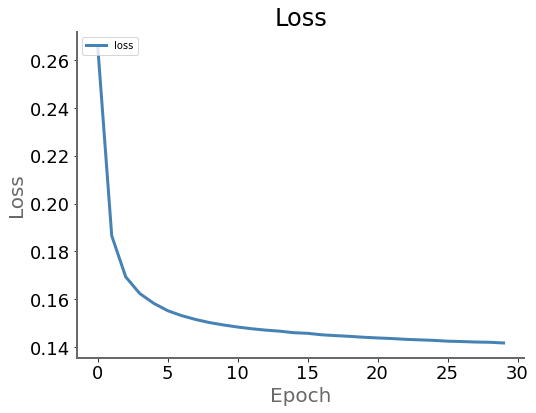

In [13]:
pwk.plot_history(history,  plot={"Loss":['loss']}, save_as='03-history')

## Step 7 - Learning progression

<br>**Real images :**

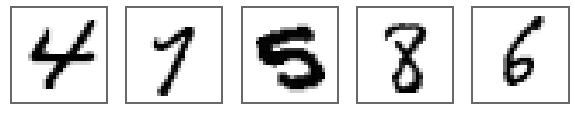

<br>**Noisy images :**

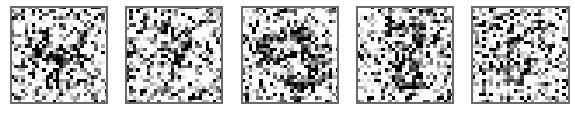

<br>**Learning...**

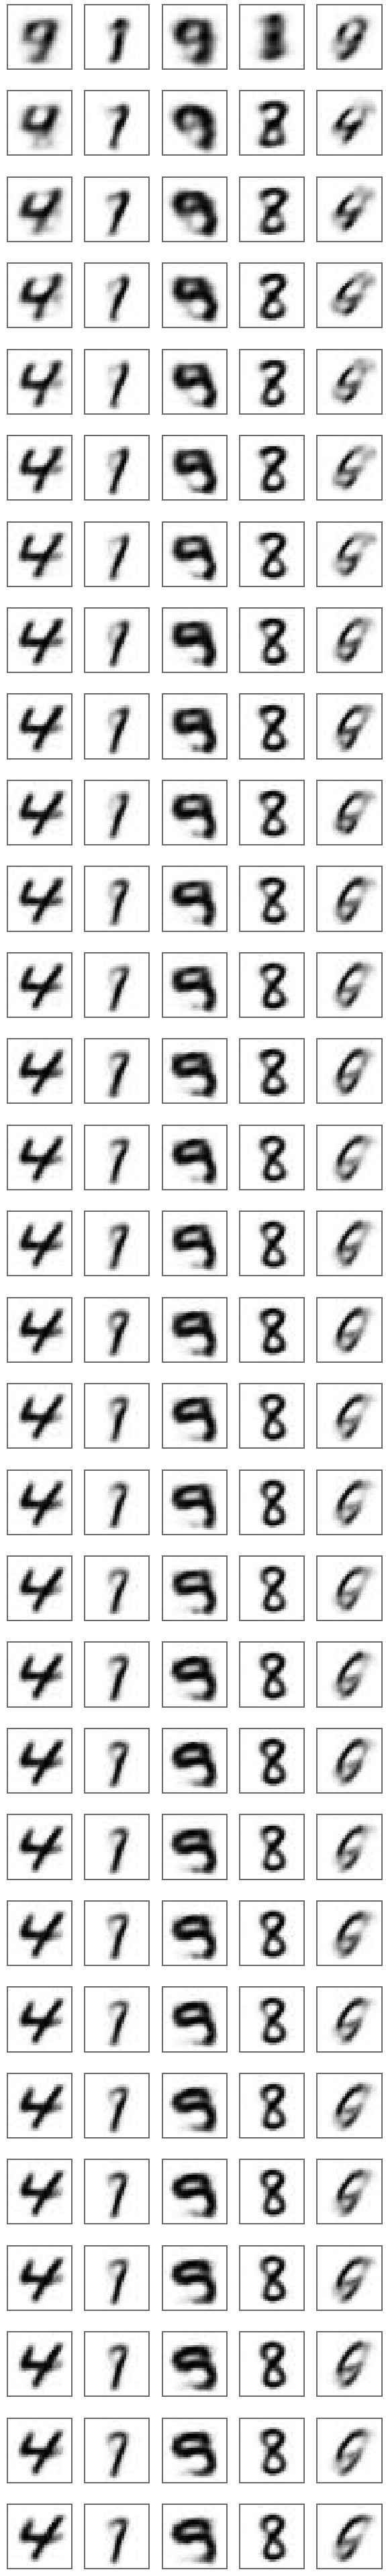

<br>**Noisy images :**

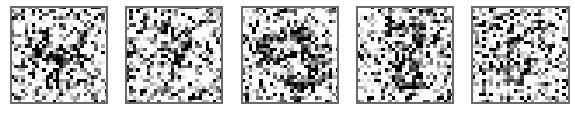

<br>**Real images :**

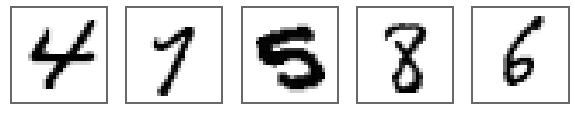

In [14]:
imgs=[]
labels=[]
for epoch in range(epochs):
    for i in range(5):
        filename = './run/images/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        

pwk.subtitle('Real images :')
pwk.plot_images(y_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='04-original-real')

pwk.subtitle('Noisy images :')
pwk.plot_images(x_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='05-original-noisy')

pwk.subtitle('Learning...')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='06-learning')

pwk.subtitle('Noisy images :')
pwk.plot_images(x_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)

pwk.subtitle('Real images :')
pwk.plot_images(y_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)


In [15]:
pwk.end()

End time is : Tuesday 09 February 2021, 19:58:18
Duration is : 00:02:08 370ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>